# Capacity Data Cleaning

This notebook works with:

- Planet Data

  * Reads raw Planet data
  * Removes duplicates from the data
  * Cleans the data by relabelling proper nans and adjusting the time dimension
  * Makes a CDF matching of data from period 1 using data from period 2 as a baseline

- ERA-5 Data

  * Reads raw ERA-5 data
  * Removes duplicates from the data
  * Cleans the data
  * Selects nearest neightbor for each pixel to match the grid of period 2
  * Makes a CDF matching of ERA-5 using data from period 2 as a baseline

After those steps we apply feature engineering functions:
  * Calculate climatology for Soil Water Content
  * Calculate anomaly and negative anomaly
  * Add crop cycles and related coordinates

After those steps:
  * Store the data as a NetCDF file

In [1]:
import sys
import os
cp = '/home/jupyter-gabriel/' #'I:/My Drive/'
sys.path.append(cp + "projects/suyana")
from scripts.utils.functions import *
#from scripts.utils.data_cleaning import *

In [2]:
# Data primary path
dpp = 'suyana/'
# Data inputs path
dip = 'suyana/inputs/'
# Data features path
dfp = 'suyana/features/'
# Data outputs path
dop = 'suyana/outputs/'
# Data reports path
drp = 'suyana/reports/'
# Data models path
dmp = 'suyana/models/'
# Data displays path
ddp = 'suyana/displays/'
# Data geometries path
dgp = 'suyana/geometries/'

## Utils

In [3]:
"""
Data Cleaning Utilities

This module provides functions for cleaning and processing datasets, including:
- Removing duplicates and filling missing values
- Performing empirical CDF matching
- Cleaning and concatenating datasets
- Filling empty time windows with generated data
"""

import numpy as np
import pandas as pd
import xarray as xr


def coarsen_data(ds, params_coarse):
    ds_new = ds.coarsen(params_coarse, boundary = 'pad').mean()
    return ds_new

def remove_duplicates(ds):
    ds_unique = ds.drop_duplicates(..., keep='first')

    return ds_unique


def clean_data(
    ds, 
    date_range = (None, None), 
    na_replace = None, 
    time_dim = 'time', 
    params_smooth = {'time':21}, 
    params_offset = {'lon':0, 'lat':0}
):
    # Remove duplicates
    if time_dim not in ds.dims:
        raise ValueError(f"Input for time_dim must be a subset of dimensions")
    ds = remove_duplicates(ds)
    
    # Convert time to datetime format
    ds[time_dim] = pd.to_datetime(ds[time_dim].values)
    
    # Create a week coordinate attached to the existing time dimension
    ds = ds.assign_coords(dict(
        week = (time_dim, ds[time_dim].dt.isocalendar().week.values)
    ))

    ds = ds.reindex(
        time=pd.date_range(
            start=ds[time_dim].min().values, end=ds[time_dim].max().values, freq="D"
        )
    )

    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        pass
    else:
        ds = ds.sel(time = slice(date_range[0], date_range[1]))
    
    # Replace values with nan (65535 for Planet)
    if isinstance(na_replace, (int, float)):
        ds = ds.where(ds != na_replace, np.nan)

    # Apply a rolling mean to have a smooth time series by pixel
    ds = ds.rolling(params_smooth, min_periods = 1).mean()

    # Adjust the coordinates by an offset value
    for key, value in params_offset.items():
        ds[key] = ds[key] + value

    return ds

def summarize_data(ds, red_dims=[None], group_coords=[None]):
    
    if set(red_dims).issubset(set(list(ds.sizes.keys()))):
        # Average over all grouping columns (dimensions)
        ds = ds.mean(dim = red_dims)
    elif set(group_coords).issubset(set(list(ds.coords))):
        for coord in group_coords:
            ds = ds.groupby(coord).mean()
    else:
        raise ValueError(f"Input for red_cols must be a subset of dimensions")
    return ds

# Function to assign a cluster to a single (lon, lat) pair
def assign_cluster(lon, lat, shapes, cluster_var):
    point = Point(lon, lat)
    for _, row in shapes.iterrows():
        if row["geometry"].contains(point):
            return row[cluster_var]  # Assuming 'cluster_id' is in the shapefile
    return np.nan  # Default if no cluster matches

def create_cluster_coord(ds, shapefile, cluster_var, lon_var='lon', lat_var='lat'):
    # Apply cluster assignment to all (lon, lat) pairs
    # Extract lon and lat from the dataset
    lon = ds[lon_var].values
    lat = ds[lat_var].values

    # Create a 2D meshgrid of (lon, lat) pairs
    lon_grid, lat_grid = np.meshgrid(lon, lat)

    # Use np.vectorize to apply the assign_cluster function
    vectorized_assign_cluster = np.vectorize(assign_cluster, excluded=["shapes", "cluster_var"])
    cluster = vectorized_assign_cluster(lon_grid, lat_grid, shapes=shapefile, cluster_var=cluster_var)

    # Add the cluster as a new coordinate to the dataset
    ds = ds.assign_coords(cluster=((lat_var, lon_var), cluster))
    
    return ds

def empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols):
    """
    Performs empirical CDF matching, handling NaN values.

    Args:
      x: The data to be adjusted.
      y: The reference data.

    Returns:
      The adjusted data.
    """
    df_base = df_orig[group_cols + [field]].copy()
    df_base['index'] = df_base.groupby(group_cols)[field].rank(method="first")
    df_base = df_base.dropna(subset=[field],axis=0)

    df_base_size = df_base.groupby(group_cols).agg(
        size=(field, 'count')
    ).reset_index()

    df_base = df_base.rename({field: field+'_adjusted'}, axis=1)
    
    df_fix['rank'] = (
        df_fix.groupby(group_cols)[field].rank(method="max")
        / df_fix.groupby(group_cols)[field].transform('count')
    )
    
    df_fix = df_fix.merge(
        df_base_size,
        how = 'left',
        on = group_cols
    )

    df_fix['index'] = np.floor(df_fix['rank']*df_fix['size'])
    
    df_fix = df_fix.merge(
        df_base[group_cols +['index', field+'_adjusted']],
        how = 'left',
        on = group_cols + ['index']
    ).drop(labels=['index', 'size', 'rank'], axis=1)

    return df_fix

def empirical_cdf_matching(df_fix, df_orig, field, group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = empirical_cdf_matching_grouped(df_fix, df_orig, field, group_cols)
    return df_fix

def cdf_matching_grouped(ds_period1, ds_period2, field, group_cols=None, time_dim = 'time', adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = empirical_cdf_matching(
        df_fix, df_base, field , group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))

    df_fix.drop(['week'], axis=1, inplace=True)

    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    #ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    
    ds_period1 = ds_period1.assign_coords(dict(
        week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    ))
    return ds_period1, ds_period2

def scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols=None):
    
    min_day = min(df_fix[time_dim].dt.dayofyear.values)
    max_day = max(df_fix[time_dim].dt.dayofyear.values)
    
    df_base = df_orig.loc[(df_orig[time_dim].dt.dayofyear >= min_day) & (df_orig[time_dim].dt.dayofyear <= max_day)].copy()

    df_base = df_base.groupby(group_cols).agg(
        mean_field = (field, 'mean'),
        std_field = (field, 'std'),
    ).reset_index()

    df_fix['local_mean'] = df_fix.groupby(group_cols)[field].transform('mean')
    df_fix['local_std'] = df_fix.groupby(group_cols)[field].transform('std')

    df_fix  = df_fix.merge(
        df_base,
        how = 'left',
        on = group_cols
    )

    df_fix[field + '_adjusted'] = ((df_fix[field] - df_fix['local_mean'])/df_fix['local_std']) *df_fix['std_field']  + df_fix['mean_field']
    
    df_fix = df_fix.drop(labels=['local_mean', 'local_std', 'std_field', 'mean_field'], axis=1)
    
    return df_fix

def scale_data(df_fix, df_orig, field, time_dim = 'time', group_cols = None):
    if group_cols is None:
        df_fix['aux__var'] = 1
        df_orig['aux__var'] = 1
        group_cols = ['aux__var']
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
        df_fix.drop(group_cols, axis=1, inplace=True)
        df_orig.drop(group_cols, axis=1, inplace=True)
    else:
        df_fix = scale_data_grouped(df_fix, df_orig, field, time_dim, group_cols)
    return df_fix

def scaling_grouped(ds_period1, ds_period2, field,  time_dim = 'time', group_cols=None, adjust_field_base = False):
    
    # Turn the xarrays into dataframes to apply the empirical_cdf_matching function
    df_fix = ds_period1.to_dataframe().reset_index()
    df_base = ds_period2.to_dataframe().reset_index()
    
    df_fix = scale_data(
        df_fix, df_base, field , time_dim, group_cols
    )
    if adjust_field_base: 
        ds_period2[field+'_adjusted'] = ds_period2[field] 
    
    # Create an xarray Dataset
    dims = list(ds_period2.sizes.keys())
    coords = list(ds_period2.coords.keys())
    drop_vars = list(set(coords) - set(dims))
    #df_fix = df_fix.drop(['week'], axis=1)
    ds_period1 = df_fix.set_index(dims).to_xarray()
    
    ds_period1 = ds_period1.set_coords(coords)
    #ds_period1 = ds_period1.drop_vars(drop_vars)
    #ds_period1 = ds_period1.assign_coords(dict(
    #    week = (time_dim, ds_period1[time_dim].dt.isocalendar().week.values)
    #))

    return ds_period1, ds_period2

def create_window_w_data(ds_orig, ds_base, date_range = (None, None)):
    
    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        ds_fill = ds_orig
    else:
        ds_fill = ds_orig.sel(time = slice(date_range[0], date_range[1]))

    # Select the nearest neighbors from the grid pixels on ds_base
    ds_fill = ds_fill.sel(
        lat = ds_base.lat, lon = ds_base.lon, method = 'nearest'
    )
    ds_fill = ds_fill.assign_coords(
        lat = ds_base.lat, 
        lon = ds_base.lon, 
        time = ds_fill.time.dt.round('d'),
        week = ('time', ds_fill.time.dt.isocalendar().week.values)
    )

    return ds_fill

def create_empty_data(ds_orig, gdf, date_range = (None, None), cluster_var='nro_cluste', lon_var='lon', lat_var='lat'):
    
    # Select data within the time window
    if date_range[0] is None and date_range[1] is None:
        ds_fill = ds_orig
    else:
        ds_fill = ds_orig.sel(time = slice(date_range[0], date_range[1]))

    # Select the nearest neighbors from the grid pixels on ds_base
    ds_fill = create_cluster_coord(ds_fill, gdf, cluster_var, lon_var, lat_var)
    ds_fill = ds_fill.assign_coords(
        time = ds_fill.time.dt.round('d'),
        week = ('time', ds_fill.time.dt.isocalendar().week.values)
    )

    return ds_fill

def concat_arrays(ds_ini, dim_along = None, *ds_arrays):
    if set([dim_along]).issubset(set(list(ds_ini.sizes.keys()))):
        # Create a list of all datasets to concatenate
        all_ds = [ds_ini] + list(ds_arrays)
        
        # Perform concatenation
        ds_final = xr.concat(all_ds, dim=dim_along)
    else:
        raise ValueError(f"Input for dim_along must be a subset of dimensions")
    
    # Sort and rename as needed
    if dim_along in ds_final.dims:
        ds_final = ds_final.sortby(dim_along)
        
    return ds_final

def add_climatology(ds, field, time_dim = 'time', dims = None):
    # Get full years only to calculate the climatology
    # Group by year and count the number of dates
    ds_days_per_year = ds[time_dim].groupby(time_dim+".year").count()

    # Filter for full years
    full_years = ds_days_per_year.where(ds_days_per_year >= 365).dropna('year')
    ds_full = ds.sel(time=ds["time.year"].isin(full_years.year))
    
    if dims == None:
        dims = [time_dim]

    if not set(dims).issubset(set(list(ds.sizes.keys()))):
        raise ValueError(f"Input for dims must be a subset of dimensions")

    climatology = ds_full[field].groupby(time_dim+".dayofyear").mean(dims)
    ds["climatology"] = xr.DataArray(
        climatology.sel(dayofyear=ds[time_dim+".dayofyear"]), 
        dims=list(ds.sizes.keys())
    )

    return ds

def add_anomaly(ds, field):
    # ds["swc"] = ds["swc_adjusted"].rolling(time=21, min_periods=1).mean()
    # First value will not be filled if it is nan, so drop it
    if ds[field].isel(time=0).isnull().any():
        ds = ds.isel(time=slice(1, None))
    ds["anomaly"] = ds[field] - ds["climatology"]
    ds["negative_anomaly"] = ds["anomaly"].where(ds["anomaly"] < 0, np.nan) * (-1)
    ds["negative_anomaly"] = ds["negative_anomaly"].fillna(0)

    return ds

def add_crop_cycles(ds, time_dim):
    # Add a crop_year coordinate and a flag of summer campaign
    ds["crop_year"] = xr.where(ds[time_dim].dt.month.isin([1,2,3,4]), ds[time_dim].dt.year-1, ds[time_dim].dt.year)
    ds["flag_summer"] = xr.where(ds[time_dim].dt.month.isin([11,12,1,2,3,4]),1,0)

    # Add a crop_cycle coordinate
    ds["crop_cycle"] = 2001 + (ds[time_dim].dt.year - 2002) + (ds[time_dim].dt.month >= 11)
    mask_feb = (ds[time_dim].dt.month == 2) & (ds[time_dim].dt.day >= 16)
    mask_mar_oct = (ds[time_dim].dt.month >= 3) & (ds[time_dim].dt.month <= 10)
    mask = mask_feb | mask_mar_oct
    ds["crop_cycle"] = ds["crop_cycle"].where(~mask)

    ds = ds.set_coords(["crop_year", "flag_summer", "crop_cycle"])
    return ds


## Data cleaning and feature engineering

In [4]:
path = dpp+"drought/swc/raw/"
path_polygons = dgp
files = os.listdir(path_polygons)
files = [f for f in files if f.endswith(".shp")]
id_canton = [int(files[i].split("_")[1].split(".")[0]) for i in range(len(files))]

In [5]:
ds_era = xr.open_dataset(dip + 'drought_soilwater_2011_2012.nc')
lat_fine = np.arange(ds_era.lat.min(), ds_era.lat.max() + 0.025, 0.025)
lon_fine = np.arange(ds_era.lon.min(), ds_era.lon.max() + 0.025, 0.025)
# Interpolate to the finer resolution
ds_interp = ds_era.interp(lat=lat_fine, lon=lon_fine, method="linear")

# Inspect the interpolated data
print(ds_interp)

<xarray.Dataset> Size: 140MB
Dimensions:  (time: 731, lat: 165, lon: 145)
Coordinates:
  * time     (time) datetime64[ns] 6kB 2011-01-01T08:00:00 ... 2012-12-31T08:...
  * lat      (lat) float64 1kB -18.9 -18.88 -18.85 ... -14.85 -14.83 -14.8
  * lon      (lon) float64 1kB -64.3 -64.27 -64.25 ... -60.75 -60.72 -60.7
Data variables:
    swc      (time, lat, lon) float64 140MB 0.4165 0.4186 0.4207 ... 0.4702 nan
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2025-01-21T15:44 GRIB to CDM+CF via cfgrib-0.9.1...


In [6]:
for id in id_canton:
    local_path = path + 'canton_' + str(id) + '/' 
    if os.path.isdir(local_path):
        pass
    else:
        print(id)

2
1


In [ ]:
gdf_list = []
for i in range(43,len(id_canton)): #[0:52] #53(canton_214) is too small that it need a finer grid # After execution [43:] 189 is denied
    print(f"Canton: {id_canton[i]}")
    local_path = path + 'canton_' + str(id_canton[i]) + '/'
    if os.path.isdir(local_path):
        files = sorted(os.listdir(local_path))
        for j in range(len(files)):
            if j==0:
                ds_period1 = xr.open_dataset(local_path + files[j])
            if j > 0:
                ds_period2 = xr.open_dataset(local_path + files[j])
                #netcdf_ini = xr.concat([netcdf_ini, netcdf_aux], dim='time')

        gdf = gpd.read_file(gp+"projects/suyana/data/capacity/planet_polygons/canton_" + str(id_canton[i]) + '.shp')
        gdf = gdf.drop_duplicates(subset = 'geometry')
        gdf['id_canton'] = id_canton[i]

        cols_to_impute = ['nro_cluste','departamen', 'provincia', 'municipio', 'canton_ori', 'area']
        gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])
        gdf['id_cluster'] = gdf['nro_cluste'].rank(method = 'first').fillna(7)

        # Get offset value for grid
        lon_offset = np.mean((ds_period2.lon.values[1:] - ds_period2.lon.values[:-1])/2)
        lat_offset = np.mean((ds_period2.lat.values[1:] - ds_period2.lat.values[:-1])/2)

        # Get boundaries of temporal window
        date_ini = max((ds_period1.time + np.timedelta64(1, "D")).dt.date.astype(str).values)
        date_fin = min((ds_period2.time - np.timedelta64(1, "D")).dt.date.astype(str).values)

        ds_period1 = clean_data(ds_period1, date_range=(None, date_ini), na_replace=65535, 
                                params_smooth = {'time':21},  params_offset={'lon':lon_offset, 'lat':lat_offset})
        ds_period2 = clean_data(ds_period2, date_range=(date_fin, '2024-10-31'), na_replace=65535, 
                                params_smooth = {'time':21}, params_offset={'lon':lon_offset, 'lat':lat_offset})
        ds_empty = clean_data(ds_interp, date_range=(date_ini, date_fin), params_smooth={'time':14})
        print(f"Cleaning done")

        ds_period1 = create_cluster_coord(ds_period1, gdf, 'id_cluster')
        ds_period2 = create_cluster_coord(ds_period2, gdf, 'id_cluster')
        ds_empty = create_cluster_coord(ds_empty, gdf, 'id_cluster')

        ds_period1 = summarize_data(ds_period1, group_coords=['cluster'])
        ds_period2 = summarize_data(ds_period2, group_coords=['cluster'])
        ds_empty = summarize_data(ds_empty, group_coords=['cluster'])
        print(f"Clustering and summarizing done")

        ds_period1, ds_period2 = cdf_matching_grouped(ds_period1, ds_period2, 'swc', group_cols=['week'], adjust_field_base=True)
        ds_empty, ds_period2 = cdf_matching_grouped(ds_empty, ds_period2, 'swc')
        print(f"CDF matching done")

        ds_concat = concat_arrays(ds_period1, 'time', ds_empty, ds_period2)
        print(f"Filling empty window and concatenating arrays done")

        ds_concat = add_climatology(ds_concat, 'swc_adjusted')
        ds_concat = add_anomaly(ds_concat, 'swc_adjusted')
        ds_concat = add_crop_cycles(ds_concat, 'time')
        print('Climatology and anomaly successfully added')

        comp = dict(zlib=True, complevel=9)
        encoding = {var: comp for var in ds_concat.data_vars}

        ds_concat.to_netcdf(
            dfp + 'drought_canton_cluster_' + str(id_canton[i]) +'.nc',
            encoding = encoding
        )

        gdf_list.append(gdf[['id_canton', 'id_cluster', 'departamen', 'provincia', 'municipio', 'canton_ori', 'area','geometry']])
    else:
        print(f'{id} not available')

Canton: 189
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 81
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 195
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 1
170 not available
Canton: 162
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 51
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 208
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays do

/tmp/ipykernel_152798/3428492684.py:19: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])


Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 129
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 86
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 55
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 72
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully added
Canton: 84
Cleaning done
Clustering and summarizing done
CDF matching done
Filling empty window and concatenating arrays done
Climatology and anomaly successfully ad

In [17]:
gdf_full = gpd.GeoDataFrame(pd.concat(gdf_list,ignore_index=True), crs=gdf_list[0].crs)
gdf_full = gdf_full.rename({
    'canton_ori': 'canton'
}, axis =1) 

In [18]:
gdf_full

id_canton  id_cluster  departamen  provincia   municipio        canton  \
0           87         4.0  Santa Cruz     Ichilo  San Carlos    San Carlos   
1           87         5.0  Santa Cruz     Ichilo  San Carlos    San Carlos   
2           87         3.0  Santa Cruz     Ichilo  San Carlos    San Carlos   
3           87         2.0  Santa Cruz     Ichilo  San Carlos    San Carlos   
4           87         1.0  Santa Cruz     Ichilo  San Carlos    San Carlos   
..         ...         ...         ...        ...         ...           ...   
373        170         2.0  Santa Cruz  Chiquitos      Pailon  Canada Larga   
374        170         4.0  Santa Cruz  Chiquitos      Pailon  Canada Larga   
375        170         3.0  Santa Cruz  Chiquitos      Pailon  Canada Larga   
376        170         6.0  Santa Cruz  Chiquitos      Pailon  Canada Larga   
377        170         1.0  Santa Cruz  Chiquitos      Pailon  Canada Larga   

           area                                           geometry  
0    601.315223  POLYGON ((-63.86994 -17.37909, -63.87078 -17.3...  
1    601.315223  POLYGON ((-63.84517 -17.43708, -63.84930 -17.4...  
2    601.315223  POLYGON ((-63.91008 -17.55857, -63.90885 -17.5...  
3    601.315223  POLYGON ((-63.84066 -17.62404, -63.84132 -17.6...  
4    601.315223  POLYGON ((-63.86230 -17.49632, -63.86371 -17.4...  
..          ...                                                ...  
373  901.079039  POLYGON ((-62.42717 -17.45970, -62.39920 -17.4...  
374  901.079039  POLYGON ((-62.39774 -17.79682, -62.31666 -17.8...  
375  901.079039  POLYGON ((-62.31666 -17.71574, -62.31327 -17.7...  
376  901.079039  POLYGON ((-62.42669 -17.59100, -62.42346 -17.5...  
377  901.079039  POLYGON ((-62.33883 -17.70835, -62.33883 -17.6...  

[378 rows x 8 columns]

In [9]:
gdf_full.to_file(dgp + 'dict_canton.gpkg', driver='GPKG')

NameError: name 'gdf_full' is not defined

In [10]:
gdf_full.plot()

NameError: name 'gdf_full' is not defined

In [57]:
import shutil

In [58]:
shutil.make_archive('cluster', "zip", 'suyana/cluster')

'/home/jupyter-gabriel/cluster.zip'

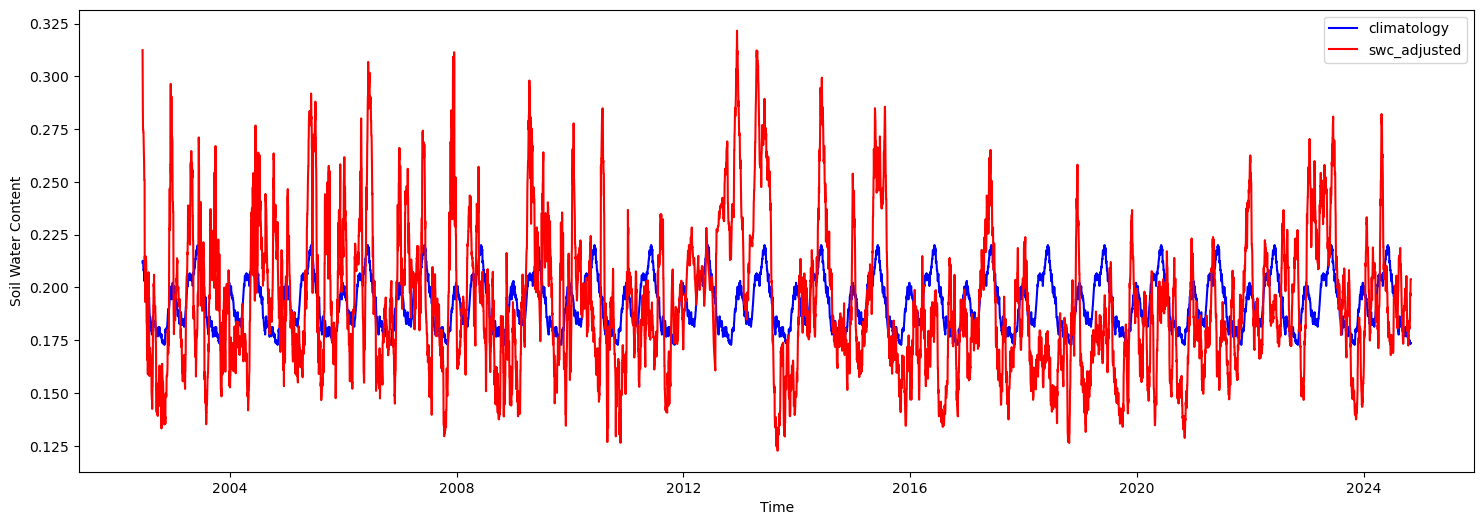

In [55]:
# Select the data at the specific location
ds_location = ds_concat.sel(cluster=1)
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.time, ds_location.climatology, label='climatology', color='blue') 
plt.plot(ds_location.time, ds_location.swc_adjusted, label='swc_adjusted', color='red')
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

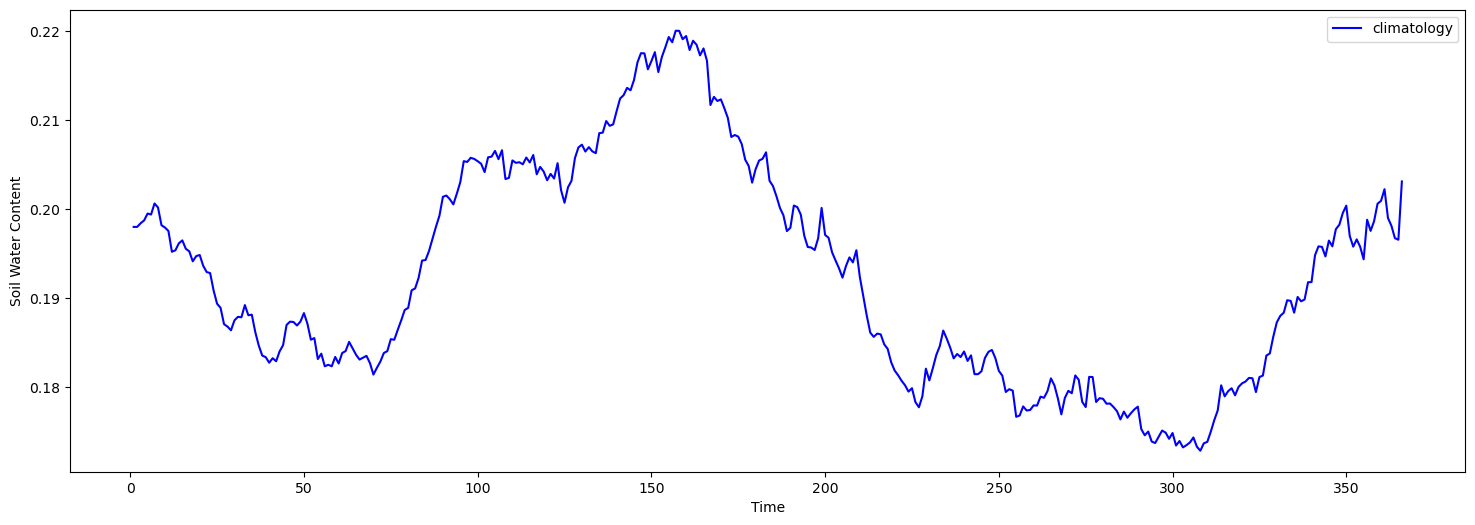

In [56]:
# Select the data at the specific location
ds_location = ds_concat.sel(cluster=1).groupby('time.dayofyear').mean()
#ds_location = ds_location.sel(time=slice('2010-10-01', '2013-07-31'))
# Plotting 
plt.figure(figsize=(18, 6)) 
plt.plot(ds_location.dayofyear, ds_location.climatology, label='climatology', color='blue') 
#plt.plot(ds_location.dayofyear, ds_location.swc_adjusted, label='swc_adjusted', color='red')
plt.xlabel('Time') 
plt.ylabel('Soil Water Content')
plt.legend()
plt.show()

# Determinar id de cantones faltantes

In [11]:
folders = os.listdir(path)
folders = [f for f in folders if f.startswith('canton')]

In [92]:
df_all = pd.DataFrame()
for i in range(len(folders)): #[0:52] #53(canton_214) is too small that it need a finer grid
    print(f"Canton: {folders[i]}")
    local_path = path + str(folders[i])
    ds = xr.open_dataset(local_path + '/' + str(folders[i]) + '_1.nc')
    ds = ds.min(dim='time')
    ds['id'] = int(folders[i][7:])
    
    df = ds.to_dataframe().reset_index()
    df = df.dropna(subset=['swc'], axis=0)
    df_all = pd.concat([df_all,df], axis=0)

Canton: canton_125
Canton: canton_78
Canton: canton_215
Canton: canton_198
Canton: canton_128
Canton: canton_106
Canton: canton_70
Canton: canton_169
Canton: canton_45
Canton: canton_53
Canton: canton_85
Canton: canton_104
Canton: canton_167
Canton: canton_162
Canton: canton_189
Canton: canton_81
Canton: canton_56
Canton: canton_82
Canton: canton_43
Canton: canton_49
Canton: canton_190
Canton: canton_191
Canton: canton_168
Canton: canton_218
Canton: canton_122
Canton: canton_55
Canton: canton_107
Canton: canton_173
Canton: canton_170
Canton: canton_214
Canton: canton_80
Canton: canton_172
Canton: canton_212
Canton: canton_83
Canton: canton_192
Canton: canton_171
Canton: canton_57
Canton: canton_165
Canton: canton_220
Canton: canton_164
Canton: canton_163
Canton: canton_202
Canton: canton_208
Canton: canton_209
Canton: canton_77
Canton: canton_129
Canton: canton_127
Canton: canton_211
Canton: canton_84
Canton: canton_199
Canton: canton_121
Canton: canton_86
Canton: canton_126
Canton: ca

In [100]:
df_all = df_all.groupby(['lon', 'lat']).agg(
    swc = ('swc', 'min'),
    id = ('id', 'min')
).reset_index()

df_all = df_all.sort_values(by=['lon','lat'])

In [101]:
ds_all = df_all.set_index(['lat','lon']).to_xarray()

In [102]:
ds_all

<xarray.Dataset> Size: 5MB
Dimensions:  (lat: 449, lon: 684)
Coordinates:
  * lat      (lat) float64 4kB -18.41 -18.4 -18.39 ... -16.07 -16.06 -16.05
  * lon      (lon) float64 5kB -64.23 -64.22 -64.21 ... -60.76 -60.75 -60.74
Data variables:
    swc      (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan nan
    id       (lat, lon) float64 2MB nan nan nan nan nan ... nan nan nan nan nan

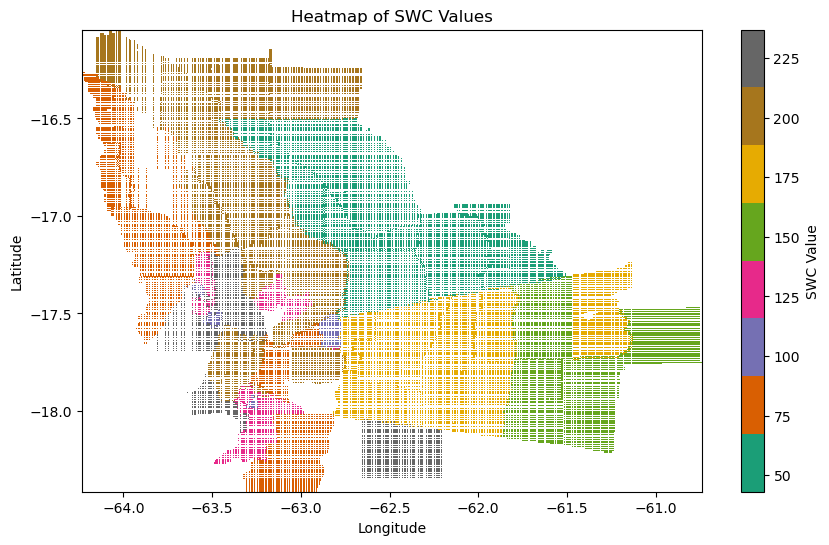

In [103]:
# Create a heatmap using pcolormesh
ds_location = ds_all#.where(ds_all.id==125)
plt.figure(figsize=(10, 6))
plt.pcolormesh(ds_location.lon, ds_location.lat, ds_location.id, cmap='Dark2', shading = 'auto')

# Add labels
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.colorbar(label="SWC Value")
plt.title("Heatmap of SWC Values")

plt.show()

# Create sequential dictionary of ids for clusters

In [ ]:
gdf_list = []
for i in range(len(id_canton)): #[0:52] #53(canton_214) is too small that it need a finer grid
    print(f"Canton: {id_canton[i]}")
    local_path = path + 'canton_' + str(id_canton[i]) + '/'
    if os.path.isdir(local_path):

        gdf = gpd.read_file(dgp+"canton_" + str(id_canton[i]) + '.shp')
        gdf = gdf.drop_duplicates(subset = 'geometry')
        gdf['id_canton'] = id_canton[i]

        cols_to_impute = ['nro_cluste','departamen', 'provincia', 'municipio', 'canton_ori', 'area']
        gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])
        gdf['id_cluster'] = gdf['nro_cluste'].rank(method = 'first').fillna(7)

        gdf_list.append(gdf[['id_canton', 'id_cluster', 'departamen', 'provincia', 'municipio', 'canton_ori', 'area','geometry']])
    else:
        print(f'{id} not available')

Canton: 87
Canton: 196
Canton: 56
Canton: 220
Canton: 120
Canton: 53
Canton: 199
Canton: 128
Canton: 172
Canton: 211
Canton: 43
Canton: 209


/tmp/ipykernel_152798/3579123143.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])


Canton: 49
Canton: 163
Canton: 168
Canton: 164
Canton: 237
Canton: 198
Canton: 126
Canton: 122
Canton: 125
Canton: 70
Canton: 218
Canton: 127
Canton: 106
Canton: 194
Canton: 166
Canton: 169
Canton: 191
Canton: 215
Canton: 57
Canton: 167
Canton: 190
Canton: 45


/tmp/ipykernel_152798/3579123143.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])
/tmp/ipykernel_152798/3579123143.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])


Canton: 54
Canton: 207
Canton: 83
Canton: 171
Canton: 80
Canton: 192
Canton: 2
170 not available
Canton: 82
Canton: 85
Canton: 189
Canton: 81
Canton: 195
Canton: 1
170 not available
Canton: 162
Canton: 51
Canton: 208
Canton: 210
Canton: 105
Canton: 173
Canton: 202
Canton: 52
Canton: 214
Canton: 165
Canton: 50
Canton: 121
Canton: 129
Canton: 86
Canton: 55
Canton: 72
Canton: 84
Canton: 158
Canton: 170


/tmp/ipykernel_152798/3579123143.py:12: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  gdf[cols_to_impute] = gdf[cols_to_impute].fillna(gdf[cols_to_impute].mode().iloc[0])


In [8]:
gdf_full = gpd.GeoDataFrame(pd.concat(gdf_list,ignore_index=True), crs=gdf_list[0].crs)
gdf_full = gdf_full.rename({
    'canton_ori': 'canton'
}, axis =1)

In [9]:
gdf_full.shape

(364, 8)

In [ ]:
gdf_list = []
gdf_list.append(gdf_full)
for id in ['001', '002']:
    gdf_aux = gpd.read_file(dgp+"canton_" + str(id) + '.shp')
    gdf = gdf.drop_duplicates(subset = 'geometry')
    gdf_aux['id_canton'] = id

    gdf_aux['id_cluster'] = gdf_aux['CLUSTER_ID'].rank(method = 'first').fillna(7) 
    print(gdf_aux.id_cluster.unique())
    
    if id == '001':
        gdf_aux = gdf_aux[['id_canton', 'id_cluster', 'departamen', 'provincia', 'municipio', 'canton_ori', 'area','geometry']].copy()

        cols_to_impute = ['departamen', 'provincia', 'municipio', 'canton_ori', 'area']
        gdf_aux[cols_to_impute] = gdf_aux[cols_to_impute].fillna(gdf_aux[cols_to_impute].mode().iloc[0])

        gdf_aux = gdf_aux.rename({
            'canton_ori': 'canton'
        }, axis =1)
        gdf_list.append(gdf_aux)
    else:
        gdf_aux = gdf_aux[['id_canton', 'id_cluster', 'departam_1', 'provincia_', 'municipio_', 'canton_o_1', 'area_2','geometry']].copy()

        cols_to_impute = ['departam_1', 'provincia_', 'municipio_', 'canton_o_1', 'area_2']
        gdf_aux[cols_to_impute] = gdf_aux[cols_to_impute].fillna(gdf_aux[cols_to_impute].mode().iloc[0])

        gdf_aux = gdf_aux.rename({
            'departam_1': 'departamen',
            'provincia_': 'provincia',
            'municipio_': 'municipio',
            'canton_o_1': 'canton',
            'area_2': 'area',
        }, axis =1)
        gdf_list.append(gdf_aux)


[1. 3. 4. 2.]
[6. 5. 1. 2. 4. 3.]


In [11]:
gdf = gpd.GeoDataFrame(pd.concat(gdf_list,ignore_index=True), crs=gdf_list[0].crs)

In [12]:
gdf.shape

(374, 8)

In [13]:

# Step 1: Calculate the centroid of all polygons grouped by id_canton
grouped = gdf.dissolve(by="id_canton", as_index=False) #Groups polygons by id and combines them into a single geometry
grouped["centroid_lon"] = round(grouped.geometry.centroid.x,1)
grouped["centroid_lat"] = round(grouped.geometry.centroid.y,1)

# Step 2: Sort by latitude (descending) and longitude (ascending)
grouped = grouped.sort_values(by=["centroid_lat", "centroid_lon"], ascending=[False, True]).reset_index(drop=True)

# Step 3: Assign new sequential IDs to each id_canton
grouped["new_id_canton"] = range(101, len(grouped) + 101)

# Step 4: Map the new_id_canton back to the original GeoDataFrame
id_map = grouped[["id_canton", "new_id_canton"]]
gdf = gdf.merge(id_map, on="id_canton", how="left")

# Step 5: Calculate centroids for each cluster
gdf["centroid_lon"] = round(gdf.geometry.centroid.x,2)
gdf["centroid_lat"] = round(gdf.geometry.centroid.y,2)

# Step 6: Sort by canton, latitude (descending) and longitude (ascending)
gdf = gdf.sort_values(by=["new_id_canton","centroid_lat", "centroid_lon"], ascending=[True, False, True]).reset_index(drop=True)

# Step 7: Assign new id_cluster
gdf["new_id_cluster"] = gdf.groupby("new_id_canton").cumcount()

# Drop intermediate columns if not needed
gdf = gdf.drop(columns=["centroid_lon", "centroid_lat"])

gdf.head(5)

/tmp/ipykernel_152798/2154662134.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grouped["centroid_lon"] = round(grouped.geometry.centroid.x,1)
/tmp/ipykernel_152798/2154662134.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  grouped["centroid_lat"] = round(grouped.geometry.centroid.y,1)
/tmp/ipykernel_152798/2154662134.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["centroid_lon"] = round(gdf.geometry.centroid.x,2)
/tmp/ipykernel_152798/2154662134.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'Geo

id_canton  id_cluster  departamen provincia  municipio     canton  \
0       189         4.0  Santa Cruz  Guarayos  El Puente  El Puente   
1       189         5.0  Santa Cruz  Guarayos  El Puente  El Puente   
2       189         2.0  Santa Cruz  Guarayos  El Puente  El Puente   
3       189         6.0  Santa Cruz  Guarayos  El Puente  El Puente   
4       189         1.0  Santa Cruz  Guarayos  El Puente  El Puente   

          area                                           geometry  \
0  1398.332915  POLYGON ((-63.65862 -16.26667, -63.66209 -16.2...   
1  1398.332915  POLYGON ((-63.56246 -16.25049, -63.58047 -16.3...   
2  1398.332915  POLYGON ((-63.17311 -16.19766, -63.17322 -16.3...   
3  1398.332915  POLYGON ((-63.38219 -16.26923, -63.40021 -16.2...   
4  1398.332915  POLYGON ((-63.45301 -16.50694, -63.45497 -16.5...   

   new_id_canton  new_id_cluster  
0            101               0  
1            101               1  
2            101               2  
3            101               3  
4            101               4

/tmp/ipykernel_152798/4229542754.py:6: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(grouped.geometry.centroid.x, grouped.geometry.centroid.y, grouped["new_id_canton"]):


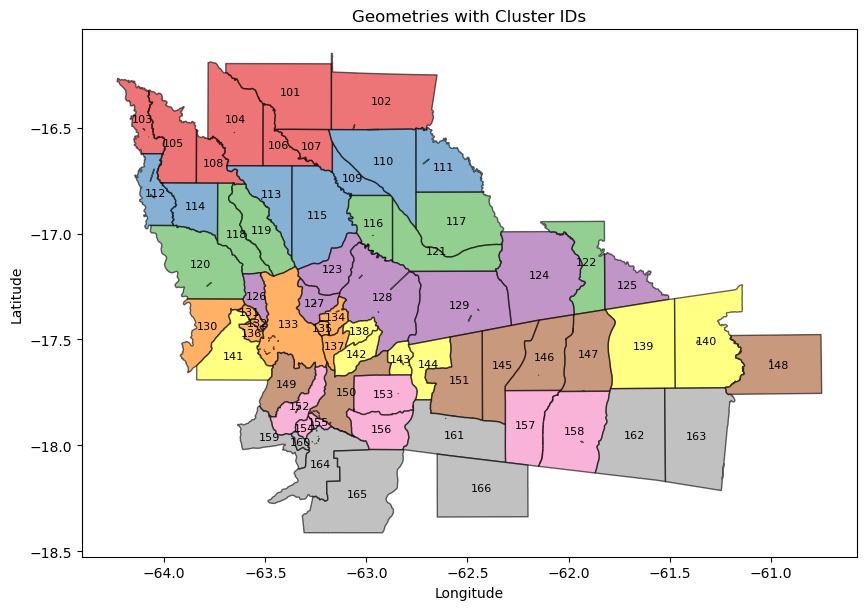

In [14]:
# Plot geometries
fig, ax = plt.subplots(figsize=(10, 10))
grouped.plot(column = 'new_id_canton', ax=ax, cmap = "Set1", edgecolor="black", alpha=0.6)

# Annotate with cluster IDs
for x, y, label in zip(grouped.geometry.centroid.x, grouped.geometry.centroid.y, grouped["new_id_canton"]):
    ax.text(x, y, str(label), fontsize=8, color="black", ha="center", va="center")

# Customize the plot
ax.set_title("Geometries with Cluster IDs")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
plt.show()

In [15]:
# Dissolve by canton to group geometries
grouped_cantons = gdf.dissolve(by="new_id_canton", as_index=False)

# Set up the cluster-level explore layer (original gdf)
cluster_layer = gdf.explore(
    column="new_id_canton",  # Color by cluster ID
    tooltip=["new_id_canton", "new_id_cluster"],  # Tooltips for clusters
    style_kwds={"fillOpacity": 0.3, "color": "black", "weight":1},  # Style for individual clusters
    cmap="Set1",  # Colormap for clusters
    tiles="CartoDB positron",
    #name="Clusters",
)

# Set up the canton-level explore layer (grouped_cantons)
canton_layer = grouped_cantons.explore(
    column="new_id_canton",  # Color by canton ID
    tooltip=["new_id_canton"],  # Tooltips for cantons
    style_kwds={"fillOpacity": 0, "color": "blue", "weight": 5},  # Thicker canton boundaries
    #cmap="tab20",  # Colormap for cantons
    #name="Cantons",
)
# Combine both layers using the base from the cluster_layer
m = cluster_layer
canton_layer.add_to(m)
m

In [ ]:
# Saving the gdf file 
gdf['id_canton'] = gdf['id_canton'].astype(int)
gdf.to_file(dgp + 'dict_canton.gpkg', driver='GPKG')

In [18]:
# Making pairs of old ids and new ids
gdf_aux = gdf[['id_canton', 'id_cluster', 'new_id_canton', 'new_id_cluster', 'new_id']].copy()
gdf_ids = gdf_aux[['id_canton', 'id_cluster', 'new_id_canton', 'new_id_cluster', 'new_id']].copy()
gdf_ids

id_canton  id_cluster  new_id_canton  new_id_cluster new_id
0          189         4.0            101               0  101-0
1          189         5.0            101               1  101-1
2          189         2.0            101               2  101-2
3          189         6.0            101               3  101-3
4          189         1.0            101               4  101-4
..         ...         ...            ...             ...    ...
369        237         4.0            166               1  166-1
370        237         2.0            166               2  166-2
371        237         5.0            166               3  166-3
372        237         3.0            166               4  166-4
373        237         6.0            166               5  166-5

[374 rows x 5 columns]

In [19]:
gdf_size = gdf_ids.groupby(['id_canton', 'id_cluster']).size()
gdf_size.sort_values(ascending=False)

id_canton  id_cluster
237        6.0           1
1          1.0           1
           2.0           1
           3.0           1
           4.0           1
                        ..
49         4.0           1
           5.0           1
           6.0           1
50         1.0           1
           2.0           1
Length: 374, dtype: int64

In [21]:
gdf_ids.to_csv(dgp + 'dict_canton.csv', index = False)

In [ ]:
# Dissolve by canton to group geometries
grouped_cantons = gdf.dissolve(by="new_id_canton", as_index=False)

# Initialize a folium map
m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)

# Add individual cluster geometries
for _, row in gdf.iterrows():
    folium.GeoJson(
        row["geometry"].__geo_interface__,
        tooltip=(
            f"Canton: {row['new_id_canton']}<br>"
            f"Cluster: {row['new_id_cluster']}<br>"
        ),
        style_function=lambda x: {
            "color": "black",
            "weight": 1,
            "fillColor": "red",
            "fillOpacity": 0.25,
        },
    ).add_to(m)

# Add canton boundaries with thicker blue lines
for _, row in grouped_cantons.iterrows():
    folium.GeoJson(
        row["geometry"].__geo_interface__,
        tooltip=f"Canton: {row['new_id_canton']}",
        style_function=lambda x: {
            "color": "blue",
            "weight": 3,  # Thicker boundaries
            "fillColor": "none",
            "fillOpacity": 0,
        },
    ).add_to(m)

for _, row in grouped_cantons.iterrows():
    lon = round(row.geometry.centroid.x,1)
    lat = round(row.geometry.centroid.y,1)
    folium.Circle(
        location=(lat,lon),
        radius=5,
        color='black',

    ).add_to(m)

# Save and display the map
m.save(ddp + "cantons_and_clusters.html")
m

/tmp/ipykernel_152798/3364052500.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  m = folium.Map(location=[gdf.geometry.centroid.y.mean(), gdf.geometry.centroid.x.mean()], zoom_start=8)
